In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

In [ ]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
sz,imgs=128,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        print('{0} {1} -> '.format(img.shape, img.dtype))
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        print('{0} {1}'.format(img.shape, img.dtype))
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
show_original_decoded(imgs[:10], imgs[:10], sz)

(362, 439, 4) uint8 -> 
(362, 439) uint8
(362, 445, 4) uint8 -> 
(362, 445) uint8
(391, 436, 4) uint8 -> 
(391, 436) uint8
(391, 439, 4) uint8 -> 
(391, 439) uint8
(582, 522, 4) uint8 -> 
(582, 522) uint8
(582, 483, 4) uint8 -> 
(582, 483) uint8
(576, 516, 4) uint8 -> 
(576, 516) uint8
(576, 508, 4) uint8 -> 
(576, 508) uint8
(557, 541, 4) uint8 -> 
(557, 541) uint8
(557, 533, 4) uint8 -> 
(557, 533) uint8
(575, 568, 4) uint8 -> 
(575, 568) uint8
(575, 577, 4) uint8 -> 
(575, 577) uint8
(1552, 1726, 4) uint8 -> 
(1552, 1726) uint8


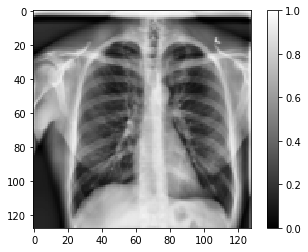

In [3]:
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



Using TensorFlow backend.


In [5]:
def build_autoencoder(sz, optimizer, loss):
    from keras.layers import Dense, Input, SpatialDropout2D
    from keras.layers import Conv2D, Flatten, Lambda
    from keras.layers import LocallyConnected2D, ZeroPadding2D
    from keras.layers import MaxPooling2D, UpSampling2D
    from keras.layers import Reshape, Conv2DTranspose
    from keras.layers import ActivityRegularization
    from keras.models import Model
    from keras.datasets import mnist
    from keras.losses import mse, binary_crossentropy
    from keras.utils import plot_model

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (5,5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 18
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (5,5), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder


In [6]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta', 
    # 'binary_crossentropy')
    'mean_squared_error')

(None, 8, 8, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   4640        max_pooling2d_2[0][0]            
____________________________________________________________________________

In [8]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12051, 128, 128, 1) (1338, 128, 128, 1)


In [18]:
autoencoder.fit(x_train, x_train, 
                epochs=256, batch_size=512, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 12051 samples, validate on 1338 samples
Epoch 1/256
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 2/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0170 - val_loss: 0.0171
Epoch 3/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0170 - val_loss: 0.0176
Epoch 4/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 5/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 6/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0167 - val_loss: 0.0172
Epoch 7/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0170 - val_loss: 0.0175
Epoch 8/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 9/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0168 - val_loss: 0.01

12051/12051 [==============================] - 15s 1ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 154/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 155/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 156/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 157/256
12051/12051 [==============================] - 15s 1ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 158/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 159/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 160/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 161/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 162/256
12051/12051 [===============

Epoch 229/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 230/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 231/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 232/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 233/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 234/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 235/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 236/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 237/256
12051/12051 [==============================] - 14s 1ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 238/256
12051/12051 [=

In [19]:
encode_only_imgs = encode_only.predict(x_test[50:60])
for n in range(10):
    print("shape of encoded = ", encode_only_imgs[2].shape)
    hist, bins = np.histogram(encode_only_imgs[2])
    print(hist)
    print(bins)

shape of encoded =  (10, 18)
[ 1  4  9 22 37 47 33 19  5  3]
[-36.50128   -29.747967  -22.994654  -16.241339   -9.488025   -2.7347107
   4.0186033  10.771917   17.525232   24.278545   31.03186  ]
shape of encoded =  (10, 18)
[ 1  4  9 22 37 47 33 19  5  3]
[-36.50128   -29.747967  -22.994654  -16.241339   -9.488025   -2.7347107
   4.0186033  10.771917   17.525232   24.278545   31.03186  ]
shape of encoded =  (10, 18)
[ 1  4  9 22 37 47 33 19  5  3]
[-36.50128   -29.747967  -22.994654  -16.241339   -9.488025   -2.7347107
   4.0186033  10.771917   17.525232   24.278545   31.03186  ]
shape of encoded =  (10, 18)
[ 1  4  9 22 37 47 33 19  5  3]
[-36.50128   -29.747967  -22.994654  -16.241339   -9.488025   -2.7347107
   4.0186033  10.771917   17.525232   24.278545   31.03186  ]
shape of encoded =  (10, 18)
[ 1  4  9 22 37 47 33 19  5  3]
[-36.50128   -29.747967  -22.994654  -16.241339   -9.488025   -2.7347107
   4.0186033  10.771917   17.525232   24.278545   31.03186  ]
shape of encoded =  

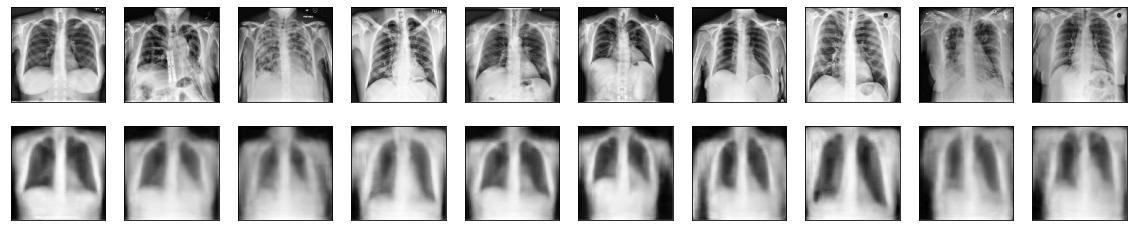

In [20]:
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test[50:60], decoded_imgs, sz)

In [21]:
import matplotlib.pyplot as plt
def g(**kwargs):
    plt.figure(2)
    latent = np.array([list(kwargs.values())])
    decoded = decode_only.predict(latent)
    plt.imshow(decoded.reshape(sz,sz))
    plt.gray()
    return kwargs['1']

In [1]:
# from ipywidgets import interactive_output,Layout
# import ipywidgets as widgets

In [2]:
# %matplotlib inline
# latent_dim = encode_only_imgs[2].shape[-1]
# kwargs = {str(k):widgets.IntSlider(value=0,min=-20,max=20,orientation='vertical',layout=Layout(padding='0%')) for k in range(latent_dim)}
# w = interactive_output(g,kwargs)
# display(widgets.HBox(list(kwargs.values()),layout=Layout(padding='0%')),w)